![Image of Yaktocat](sendy.jpg)

# Sendy Logistics Regression Model
<br></br>


## Introduction

Sendy is a business-to-business platform established in 2014, to enable businesses of all types and sizes to transport goods more efficiently across East Africa.

Logistics is fundamental to the success of a business while efficient and affordable logistics are a vital component of economic development. To help Sendy achieve affordability and effieciency, a prediction of the estimated time of delivery of orders, from the point of driver pickup to the point of arrival at final destination is made. This prediction will enhance customer communication and improve the reliability of its service; which will ultimately improve customer experience.

The prediction will enable Sendy to realise cost savings, and ultimately reduce the cost of doing business, through improved resource management and planning for order scheduling. The accurate arrival time prediction will help all businesses involved to improve their logistics and communicate an accurate time to their customers.

## Importing the Libraries

In [2]:
import numpy as np 
import math
# data processing
import pandas as pd 

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn import tree

#Varrible selection
from statsmodels.graphics.correlation import plot_corr
from statsmodels.formula.api import ols
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV

C:\Users\ELTON\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Getting the Data

In [3]:
# the csv files are converted to panda dataframe and are renamed.
Train_df= pd.read_csv("Train.csv")
Test_df= pd.read_csv("Test.csv")
Riders_df= pd.read_csv("Riders.csv")
VariableDefinitions_df= pd.read_csv("VariableDefinitions.csv")
SampleSubmission_df= pd.read_csv("SampleSubmission.csv")


## Data Description

Exploring data sets helps in developing deep understanding about the data, the data set is Explored with imported libraries.The Variable dataframe below displays the name of features and desciptions on the right.

In [14]:
VariableDefinitions_df

,Order No,Unique number identifying the order
0,User Id,Unique number identifying the customer on a pl...
1,Vehicle Type,"For this competition limited to bikes, however..."
2,Platform Type,"Platform used to place the order, there are 4 ..."
3,Personal or Business,Customer type
4,Placement - Day of Month,Placement - Day of Month i.e 1-31
5,Placement - Weekday (Mo = 1),Placement - Weekday (Monday = 1)
6,Placement - Time,Placement - Time - Time of day the order was p...
7,Confirmation - Day of Month,Confirmation - Day of Month i.e 1-31
8,Confirmation - Weekday (Mo = 1),Confirmation - Weekday (Monday = 1)
9,Confirmation - Time,Confirmation - Time - Time of day the order wa...


The dataframe above is the list of the features with a short description:

In [15]:
VariableDefinitions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 2 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Order No                             34 non-null     object
 1   Unique number identifying the order  33 non-null     object
dtypes: object(2)
memory usage: 688.0+ bytes


In [16]:
#Train data set
Train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Order No                                   21201 non-null  object 
 1   User Id                                    21201 non-null  object 
 2   Vehicle Type                               21201 non-null  object 
 3   Platform Type                              21201 non-null  int64  
 4   Personal or Business                       21201 non-null  object 
 5   Placement - Day of Month                   21201 non-null  int64  
 6   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 7   Placement - Time                           21201 non-null  object 
 8   Confirmation - Day of Month                21201 non-null  int64  
 9   Confirmation - Weekday (Mo = 1)            21201 non-null  int64  
 10  Confirmation - Time   

The training-set has 21201 entries and 28 features + the target variable (Time from Pickup to Arrival). 6 of the features are floats, 13 are integers and 10 are objects.Since there is a Train data set, this implies that the data has been split and any aditing that will be done on the train data set will also be applied on the Test data set.

In [17]:
Train_df.head(8)

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214
5,Order_No_7408,User_Id_1342,Bike,3,Business,14,5,3:07:35 PM,14,5,...,4:23:41 PM,9,27.2,NaN,-1.302583,36.767081,-1.257309,36.806008,Rider_Id_124,3191
6,Order_No_22680,User_Id_2803,Bike,3,Business,9,5,9:33:45 AM,9,5,...,10:19:45 AM,5,20.3,NaN,-1.279395,36.825364,-1.276574,36.851365,Rider_Id_114,1380
7,Order_No_21578,User_Id_1075,Bike,3,Business,11,1,2:13:01 PM,11,1,...,2:33:26 PM,3,28.7,NaN,-1.252796,36.800313,-1.255189,36.782203,Rider_Id_913,646


From the table above,few things can be noted. some of the features need to be converted into numeric ones, so that the machine learning algorithms can process them. Furthermore. Some more features, that contain missing values (NaN = not a number) can also be spoted, that would be deal with later on.

In [18]:
Train_df.columns.values

array(['Order No', 'User Id', 'Vehicle Type', 'Platform Type',
       'Personal or Business', 'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)',
       'Pickup - Time', 'Arrival at Destination - Day of Month',
       'Arrival at Destination - Weekday (Mo = 1)',
       'Arrival at Destination - Time', 'Distance (KM)', 'Temperature',
       'Precipitation in millimeters', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'Rider Id',
       'Time from Pickup to Arrival'], dtype=object)

Above are all features present in the Train data frame

In [19]:
    # Rider data set
Riders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rider Id        960 non-null    object 
 1   No_Of_Orders    960 non-null    int64  
 2   Age             960 non-null    int64  
 3   Average_Rating  960 non-null    float64
 4   No_of_Ratings   960 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 37.6+ KB


Rider_df displays the information about the motorbike riders. It consist of 5 features and 960 entries.

In [20]:
Riders_df.head(8)

,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Rider_Id_396,2946,2298,14.0,1159
1,Rider_Id_479,360,951,13.5,176
2,Rider_Id_648,1746,821,14.3,466
3,Rider_Id_753,314,980,12.5,75
4,Rider_Id_335,536,1113,13.7,156
5,Rider_Id_720,2608,1798,13.2,504
6,Rider_Id_95,3464,1304,13.4,950
7,Rider_Id_122,4831,2124,14.1,1469


Above is the overview of the Riders data frame. The feature (Rider Id) is common to both Riders and Train Data Frame this allows for a merge between the two data frames.

In [21]:
#features found within the Rider data set.
Riders_df.columns.values

array(['Rider Id', 'No_Of_Orders', 'Age', 'Average_Rating',
       'No_of_Ratings'], dtype=object)

In [22]:
    #a look at the submission sample data frame
SampleSubmission_df.head(8)

,Order_No,Time from Pickup to Arrival
0,Order_No_19248,567.0
1,Order_No_12736,4903.0
2,Order_No_768,5649.0
3,Order_No_15332,NaN
4,Order_No_21373,NaN
5,Order_No_14573,NaN
6,Order_No_6731,NaN
7,Order_No_18436,NaN


The sample submission displays the format in which sumbmision would be made for this predict on Zindi

## __DATA PREPROCESSING__

## Data cleaning and formating

In [4]:
    #Joining the riders to both Train and Test data set
Train_df = pd.merge(Train_df, Riders_df, left_on='Rider Id', 
                    right_on='Rider Id', how='left')
Test_df = pd.merge(Test_df, Riders_df, left_on='Rider Id',
                    right_on='Rider Id', how='left')

Test and Train data frames are merged with Riders data data frame on the Rider Id feature because the features in the Rider data frame may have influence on the predict variable.

In [86]:
Train_df.head(8)

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993,396,339,13.6,69
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455,1023,242,12.5,114
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341,886,283,14.5,113
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214,2311,872,14.1,533
5,Order_No_7408,User_Id_1342,Bike,3,Business,14,5,3:07:35 PM,14,5,...,-1.302583,36.767081,-1.257309,36.806008,Rider_Id_124,3191,3288,1204,14.2,1056
6,Order_No_22680,User_Id_2803,Bike,3,Business,9,5,9:33:45 AM,9,5,...,-1.279395,36.825364,-1.276574,36.851365,Rider_Id_114,1380,288,556,13.7,27
7,Order_No_21578,User_Id_1075,Bike,3,Business,11,1,2:13:01 PM,11,1,...,-1.252796,36.800313,-1.255189,36.782203,Rider_Id_913,646,4036,2119,14.4,700


Above is the new merged Train data set and The same is be done for the Test data set. For the purpose of this predict, the Vehicle Type feature is dropped because only motor bikes are considered. The naming format is not consistant in the above data frame(under scores will be use instead of spaces) and Features User Id, Rider ID and Order number will be dropped but the Order No from the Test df will not be dropped since it is require dor the submission.

In [5]:
print('There are', Train_df['Rider Id'].nunique(), 
      'Motorbike riders', 'and', Train_df['User Id'].nunique(), 
      'Customers')

There are 924 Motorbike riders and 3186 Customers


In [6]:
    # Formatting the naming of the columns
Train_df.columns = Train_df.columns.str.replace(' ', '_')
Test_df.columns = Test_df .columns.str.replace(' ', '_')

    #removing "-" from the feature labels.
Train_df.columns = Train_df.columns.str.replace('_-_', '_')
Test_df.columns = Test_df .columns.str.replace('_-_', '_')


In [127]:
Train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 33 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Order_No                                 21201 non-null  object 
 1   User_Id                                  21201 non-null  object 
 2   Vehicle_Type                             21201 non-null  object 
 3   Platform_Type                            21201 non-null  int64  
 4   Personal_or_Business                     21201 non-null  object 
 5   Placement_Day_of_Month                   21201 non-null  int64  
 6   Placement_Weekday_(Mo_=_1)               21201 non-null  int64  
 7   Placement_Time                           21201 non-null  object 
 8   Confirmation_Day_of_Month                21201 non-null  int64  
 9   Confirmation_Weekday_(Mo_=_1)            21201 non-null  int64  
 10  Confirmation_Time                        21201

In [7]:
Train_df = Train_df.drop(['Vehicle_Type', 
                          'Arrival_at_Destination_Day_of_Month',
                          'Arrival_at_Destination_Weekday_(Mo_=_1)',
                          'Arrival_at_Destination_Time', 'Order_No', 
                          'User_Id', 'Rider_Id'], axis = 1)
Test_df = Test_df.drop(['Vehicle_Type', 'User_Id', 'Rider_Id'], axis = 1)

The underscores are not applied the the predict vriable becuse that is how they will be submitted.

In [23]:
Train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 35 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Order_No                                 21201 non-null  object 
 1   User_Id                                  21201 non-null  object 
 2   Vehicle_Type                             21201 non-null  object 
 3   Platform_Type                            21201 non-null  int64  
 4   Personal_or_Business                     21201 non-null  object 
 5   Placement_Day_of_Month                   21201 non-null  int64  
 6   Placement_Weekday_(Mo_=_1)               21201 non-null  int64  
 7   Placement_Time                           21201 non-null  float64
 8   Confirmation_Day_of_Month                21201 non-null  int64  
 9   Confirmation_Weekday_(Mo_=_1)            21201 non-null  int64  
 10  Confirmation_Time                        21201

__Handling missing data__

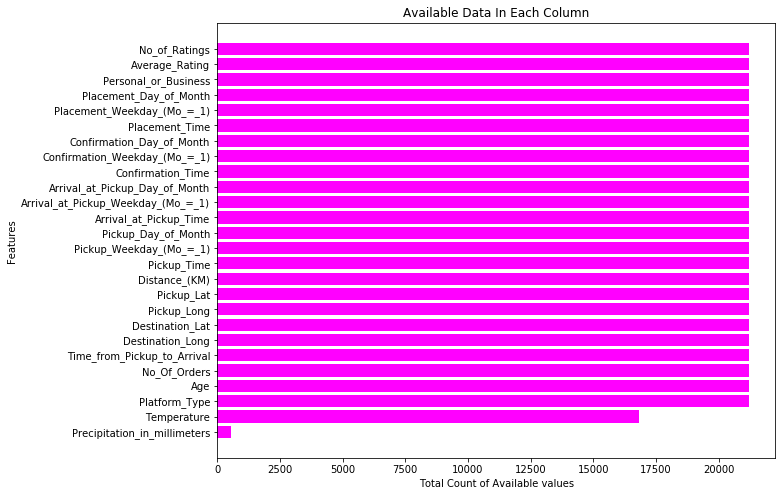

In [8]:
aval_df = Train_df.notnull().sum(axis=0).reset_index()
aval_df.columns = ['column_name', 'missing_count']
aval_df = aval_df.loc[aval_df['missing_count']>0]
aval_df = aval_df.sort_values(by='missing_count')

ind = np.arange(aval_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,8))
rects = ax.barh(ind, aval_df.missing_count.values, color='magenta')
ax.set_yticks(ind)
ax.set_yticklabels(aval_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Total Count of Available values")
ax.set_ylabel("Features")
ax.set_title("Available Data In Each Column")
plt.show()

The chart above display how much data is available, the full bars means the data for that feature is comple and the last two bar bars are the only ones with missing data.

__More detailed look at what data is actually missing:__

In [9]:
 #Train_df missing data
total = Train_df.isnull().sum().sort_values(ascending=False)
percent_1 = Train_df.isnull().sum()/Train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Precipitation_in_millimeters,20649,97.4
Temperature,4366,20.6
No_of_Ratings,0,0.0
Pickup_Day_of_Month,0,0.0
Personal_or_Business,0,0.0


Text(0, 0.5, 'Features')

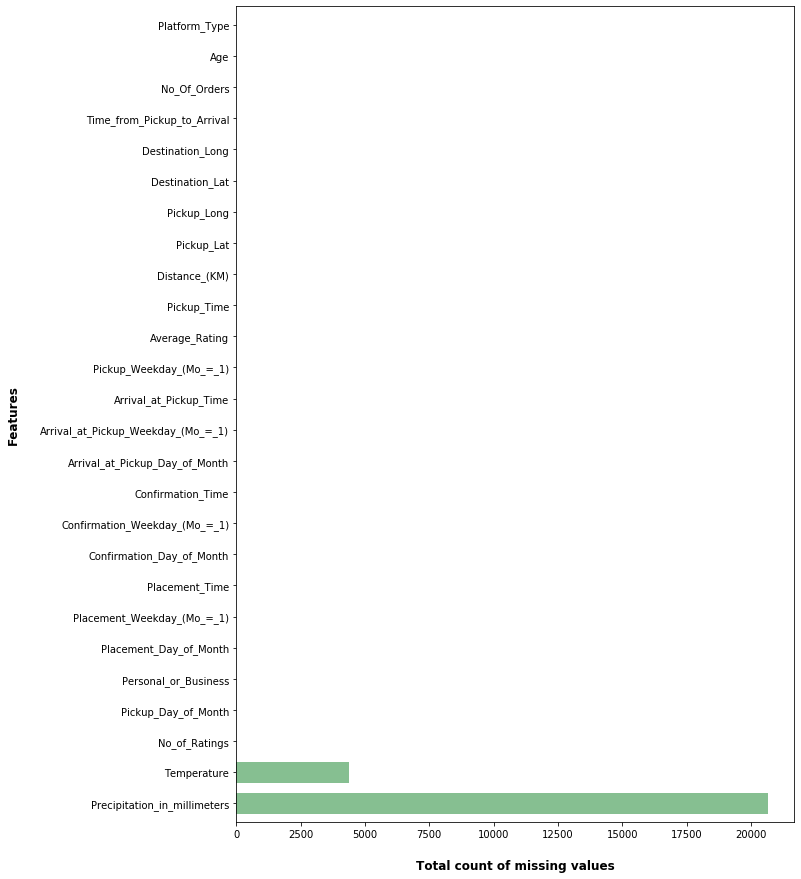

In [10]:
#Visual Display of missing Data
ax = missing_data['Total'].plot(kind='barh', figsize=(10, 15), color='#86bf91', zorder=2, width=0.68)
    # Set x-axis label
ax.set_xlabel("Total count of missing values", labelpad=20, weight='bold', size=12)

  # Set y-axis label
ax.set_ylabel("Features", labelpad=20, weight='bold', size=12)

As obseved from both missing_data frame and the visual display above, it will be a bit tricky to deal with the 'Temparature' feature, which has 4366 missing values. However on the other hand, the 'Precipitation in mm' feature needs further investigation, but it looks like it would be better if it is dropped off from the dataset, since 97.4 % of it is missing data.

*Investigating on Precipitation in millimeter feature.*

In [31]:
    #Checking if there are 0 mm records of Precipitation from both Test and Train data frame
(Train_df['Precipitation_in_millimeters']==0).all(),(Test_df['Precipitation_in_millimeters']==0).all()


(False, False)

The are no Recorded 0 values for precipitation in both of the data frames. It is not likely that pricipitation may occur in all days of the month. So it makes sense that 97% of the time in a month there is no precipitation, therefore the NaN values will be replaced with 0 values.Meaning on those days there was no precipitation.

In [11]:
    #replacing NAN with 0 for precipitation feature
Train_df["Precipitation_in_millimeters"] = Train_df["Precipitation_in_millimeters"].fillna(0)
Test_df["Precipitation_in_millimeters"] = Test_df["Precipitation_in_millimeters"].fillna(0)

In [131]:
Train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 26 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Platform_Type                       21201 non-null  int64  
 1   Personal_or_Business                21201 non-null  object 
 2   Placement_Day_of_Month              21201 non-null  int64  
 3   Placement_Weekday_(Mo_=_1)          21201 non-null  int64  
 4   Placement_Time                      21201 non-null  object 
 5   Confirmation_Day_of_Month           21201 non-null  int64  
 6   Confirmation_Weekday_(Mo_=_1)       21201 non-null  int64  
 7   Confirmation_Time                   21201 non-null  object 
 8   Arrival_at_Pickup_Day_of_Month      21201 non-null  int64  
 9   Arrival_at_Pickup_Weekday_(Mo_=_1)  21201 non-null  int64  
 10  Arrival_at_Pickup_Time              21201 non-null  object 
 11  Pickup_Day_of_Month                 21201

Checking from the infomation above, temparature is now the only feature with missing values.

Checking for relatinship between Temparature and features which may have influence of Time from Pickup to Arrival

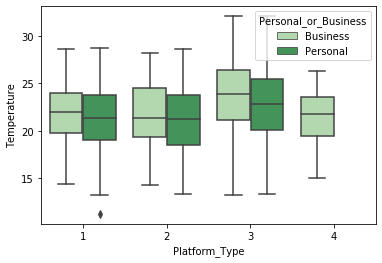

In [34]:
    #Train_df data set 
Temp = sns.boxplot(x="Platform_Type", y="Temperature", hue="Personal_or_Business",
                 data=Train_df, palette="Greens")


The whisker and the box diagram propose that there is a relationship between the temparature and the platform as well as the Personal or bussiness feature.

In [12]:
    #repacing the missing temparature with the mean
Train_df = Train_df.fillna(Train_df.mean())
Test_df = Test_df.fillna(Test_df.mean())

__*Data formating*__

There are Four features containg time data but as an object:

- Placement_Time
- Confirmation - Time
- Arrival_at_Pickup_Time
- Pickup_Time

In [13]:
def alter_time(df):
    time_matrix = ['Placement_Time','Confirmation_Time', 
                   'Arrival_at_Pickup_Time', 'Pickup_Time']
    for i in time_matrix:
        df[i] = pd.to_datetime(df[i]).dt.strftime('%H:%M:%S')
        df[i] = pd.to_timedelta(df[i])
        df[i] = df[i].dt.total_seconds()
        
    return df

In [14]:
Train_df = alter_time(Train_df)
Test_df = alter_time(Test_df)

In [15]:
Train_df.head(2)

,Platform_Type,Personal_or_Business,Placement_Day_of_Month,Placement_Weekday_(Mo_=_1),Placement_Time,Confirmation_Day_of_Month,Confirmation_Weekday_(Mo_=_1),Confirmation_Time,Arrival_at_Pickup_Day_of_Month,Arrival_at_Pickup_Weekday_(Mo_=_1),...,Precipitation_in_millimeters,Pickup_Lat,Pickup_Long,Destination_Lat,Destination_Long,Time_from_Pickup_to_Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,3,Business,9,5,34546.0,9,5,34810.0,9,5,...,0.0,-1.317755,36.830370,-1.300406,36.829741,745,1637,1309,13.8,549
1,3,Personal,12,5,40576.0,12,5,41001.0,12,5,...,0.0,-1.351453,36.899315,-1.295004,36.814358,1993,396,339,13.6,69


New Time features:

    - Placement_to_Confiration_Time
Accordin to data from Sendy; there is a missing time feature 'Arrival at Destination Time' 


In [16]:
Train_df['Placement_to_Confiration_Time'] = Train_df['Confirmation_Time'] - Train_df['Placement_Time']
Test_df['Placement_to_Confiration_Time'] = Test_df['Confirmation_Time'] - Test_df['Placement_Time'] 

#### Creating a feature from Coordinates

The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes.

Below is the fuction that will calculate the disdance between the pickup and destination location in Kilo meters

In [17]:
def haversine_vectorize(lon1, lat1, lon2, lat2): 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2]) 
    newlon = lon2 - lon1
    newlat = lat2 - lat1 
    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2
 
    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist #6367 for distance in KM(radius of the Earth)
    return round(km, 0)

In [18]:
distance_1 = haversine_vectorize(Train_df['Pickup_Lat'], 
                               Train_df['Pickup_Long'], 
                               Train_df['Destination_Lat'], 
                               Train_df['Destination_Long'])
Train_df['Actual_Distance'] = distance_1
distance_2 = haversine_vectorize(Train_df['Pickup_Lat'], 
                               Train_df['Pickup_Long'], 
                               Train_df['Destination_Lat'], 
                               Train_df['Destination_Long'])
Test_df['Actual_Distance'] = distance_2

# EDA

Exploring the features in the data frame

#### A first look at the behaviour of delivery time (Y - Variable)

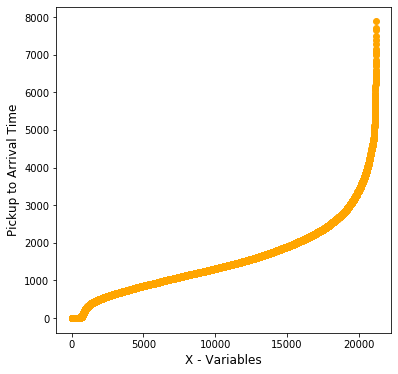

In [139]:
plt.figure(figsize=(6,6))
plt.scatter(range(Train_df.shape[0]), np.sort(Train_df['Time_from_Pickup_to_Arrival'].values), 
            color = 'orange')
plt.xlabel('X - Variables', fontsize=12)
plt.ylabel('Pickup to Arrival Time', fontsize=12)
plt.show()

 ## *Thasamy will add interpretation*

We are going to look at the Platform Type and Business type to look at what makes up most of the orders.

## Understanding The Distribution Of The Data
We are going to look at the features contained in the dataframe independently.This will help with understanding the distribution of the ranges and/or types contained in each.

### Categorical data

A look at the Platform Type and Business or Personal features to see at what makes up most of the orders.

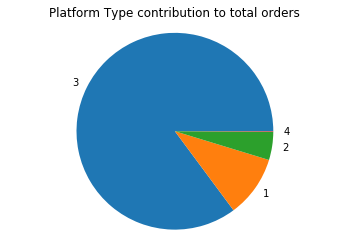

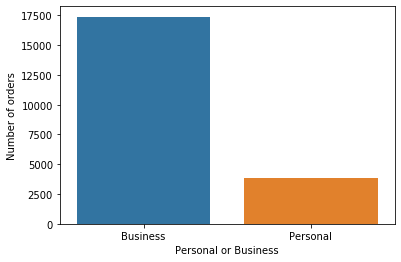

In [140]:
Train_df['Platform_Type'].value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('Platform Type contribution to total orders')
plt.ylabel('')
plt.show()

ax=sns.countplot(x='Personal_or_Business', data=Train_df)
ax.set(xlabel='Personal or Business', ylabel='Number of orders')
plt.show()

From the two figures, one can see that platfrom 3 has the highest numbers of orders and platform 4 has the least numbers. It can also be seen from the barchart that there are more orders for business than there are for personal.

## Numerical data

### Placement and confirmation Day of the month

Placement and confirmation day of the month can be the same. If they are, it will save time that only one of the features is looked at. To check that, a new dataframe is created with rows that pass the condition that confirmation day is the same as placement day of the month. After it is created, if its length is still 21201 then this proves they are the same.

In [44]:
New_df=Train_df[Train_df['Placement_Day_of_Month']!=Train_df['Confirmation_Day_of_Month']]
New_df

,Platform_Type,Personal_or_Business,Placement_Day_of_Month,Placement_Weekday_(Mo_=_1),Placement_Time,Confirmation_Day_of_Month,Confirmation_Weekday_(Mo_=_1),Confirmation_Time,Arrival_at_Pickup_Day_of_Month,Arrival_at_Pickup_Weekday_(Mo_=_1),...,Destination_Lat,Destination_Long,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Placement_to_Confiration_Time,Pickup_to_Arival_at_Pickup_Time,Actual_Distance
4024,3,Business,17,1,52477.0,18,2,47813.0,18,2,...,-1.281754,36.832423,2640,1242,623,14.0,106,-4664.0,-127.0,6.0
9804,3,Business,11,2,44525.0,13,4,48450.0,13,4,...,-1.255189,36.782203,1854,2481,752,14.3,322,3925.0,-1269.0,6.0


In [45]:
New_df=Train_df[Train_df['Placement_Weekday_(Mo_=_1)']!=Train_df['Confirmation_Weekday_(Mo_=_1)']]
New_df

,Platform_Type,Personal_or_Business,Placement_Day_of_Month,Placement_Weekday_(Mo_=_1),Placement_Time,Confirmation_Day_of_Month,Confirmation_Weekday_(Mo_=_1),Confirmation_Time,Arrival_at_Pickup_Day_of_Month,Arrival_at_Pickup_Weekday_(Mo_=_1),...,Destination_Lat,Destination_Long,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Placement_to_Confiration_Time,Pickup_to_Arival_at_Pickup_Time,Actual_Distance
4024,3,Business,17,1,52477.0,18,2,47813.0,18,2,...,-1.281754,36.832423,2640,1242,623,14.0,106,-4664.0,-127.0,6.0
9804,3,Business,11,2,44525.0,13,4,48450.0,13,4,...,-1.255189,36.782203,1854,2481,752,14.3,322,3925.0,-1269.0,6.0


interptre the above

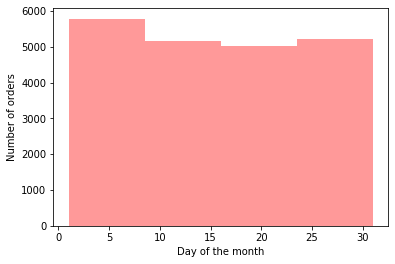

In [141]:
sns.distplot(Train_df['Placement_Day_of_Month'],bins=4,kde=False, color='red')
plt.xlabel('Day of the month')
plt.ylabel('Number of orders')
plt.rcParams["patch.force_edgecolor"] = True
plt.show()

interpretation chego

### Distance

The distance is looked at to see the range that contributes the most to the orders. The distance (Km) is divided into 5 ranges and is shown below.

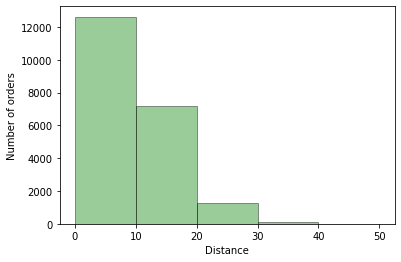

In [142]:
sns.distplot(Train_df['Distance_(KM)'], bins=np.arange(0,60,10),kde=False, color='green')
ax.set(xlabel='Distance(Km)', ylabel='Number of orders')
plt.rcParams["patch.force_edgecolor"] = True
plt.xlabel('Distance')
plt.ylabel('Number of orders')
plt.show()

The figure above shows that most of the orders are for a traveling distance of between 0km and 10km. Few orders are from a range 30km and 40km.

### Temparature and Precipitation
Now looking at both the temperature data and precipitation data, it can be seen that these are the only features with missing values. The graphs for boths are shown below.

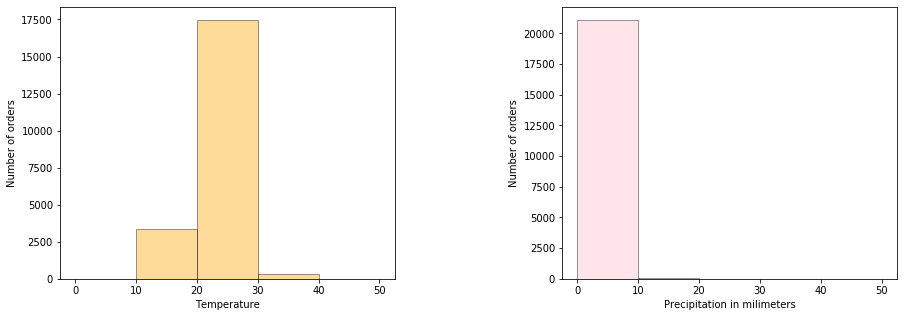

In [143]:
fig, axes = plt.subplots(1, 2,figsize=(15,5))


sns.distplot(Train_df['Temperature'],ax=axes[0], bins=np.arange(0,60,10),kde=False, color='orange')
ax.set(xlabel='Temperature', ylabel='Number of orders')
plt.rcParams["patch.force_edgecolor"] = True
plt.xlabel('Distance')
plt.ylabel('Number of orders')

sns.distplot(Train_df['Precipitation_in_millimeters'],ax=axes[1], bins=np.arange(0,60,10),kde=False, color='pink')
ax.set(xlabel='Precipitation in millimeters', ylabel='Number of orders')
plt.rcParams["patch.force_edgecolor"] = True
plt.xlabel('Distance')
plt.ylabel('Number of orders')

axes[0].set(xlabel="Temperature", ylabel="Number of orders")
axes[1].set(xlabel="Precipitation in milimeters", ylabel="Number of orders")
fig.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
#####interprt

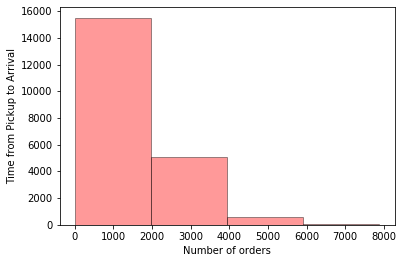

In [144]:
sns.distplot(Train_df['Time_from_Pickup_to_Arrival'],bins=4,kde=False, color='red')
plt.xlabel('Number of orders')
plt.ylabel('Time from Pickup to Arrival')
plt.rcParams["patch.force_edgecolor"] = True
plt.show()

# !!! chego how do you interprete the above.....nb Histogram are normaly used for categorigal data with numeric....

Scatter plot to display the above histplot

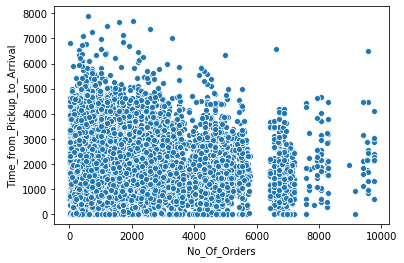

In [145]:
T_PA_no_orders = sns.scatterplot(y="Time_from_Pickup_to_Arrival", x ="No_Of_Orders",  data=Train_df)

the scatter show that the time from pickup to arival does not depend on no of orders

!!!! the above count plot is hard to interprete

### Geography And Coordinates

In [ ]:
color = sns.color_palette()
ggplot(aes(x='Pickup_Lat', y='Pickup_Long', color= 'Time from Pickup to Arrival'), data=Train_df) + \
    geom_point() + \
    scale_color_gradient(low = 'red', high = 'blue')

In [ ]:

ggplot(aes(x='Destination_Lat', y='Destination_Long', color= 'Time_from_Pickup_to_Arrival'), data=Train_df) + \
    geom_point() + \
    scale_color_gradient(low = 'blue', high = 'yellow')

### Observation

The distance of drop-offs are wider spread than pick up points, many destinations arrival time will be influenced by wider distances. We also notice that lengthy times for deliveries occur in both the central and outlier destinations. Traffic congestion and distance are all influential in the pick to arrival time duration

## Variables and Variable Selection

## Summary Statistics

In this section, the data types and the summary statistics of the variables are explored.
Looking at the data types and number of entries of each column.

In [19]:
Train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 28 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Platform_Type                       21201 non-null  int64  
 1   Personal_or_Business                21201 non-null  object 
 2   Placement_Day_of_Month              21201 non-null  int64  
 3   Placement_Weekday_(Mo_=_1)          21201 non-null  int64  
 4   Placement_Time                      21201 non-null  float64
 5   Confirmation_Day_of_Month           21201 non-null  int64  
 6   Confirmation_Weekday_(Mo_=_1)       21201 non-null  int64  
 7   Confirmation_Time                   21201 non-null  float64
 8   Arrival_at_Pickup_Day_of_Month      21201 non-null  int64  
 9   Arrival_at_Pickup_Weekday_(Mo_=_1)  21201 non-null  int64  
 10  Arrival_at_Pickup_Time              21201 non-null  float64
 11  Pickup_Day_of_Month                 21201

The Train_df.info() specifically outputs the number of non-null entries in each column. As such,It can be certain that the data has missing values if columns have a varying number of non-null entries.

Below is the table showcasing the summary statistics of the data.

In [20]:
Train_df.describe()

,Platform_Type,Placement_Day_of_Month,Placement_Weekday_(Mo_=_1),Placement_Time,Confirmation_Day_of_Month,Confirmation_Weekday_(Mo_=_1),Confirmation_Time,Arrival_at_Pickup_Day_of_Month,Arrival_at_Pickup_Weekday_(Mo_=_1),Arrival_at_Pickup_Time,...,Pickup_Long,Destination_Lat,Destination_Long,Time_from_Pickup_to_Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Placement_to_Confiration_Time,Actual_Distance
count,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,...,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000
mean,2.752182,15.653696,3.240083,46182.663695,15.653837,3.240225,46615.894816,15.653837,3.240225,47392.416254,...,36.811264,-1.282581,36.811220,1556.920947,1692.423706,984.742842,13.882520,341.067119,433.231121,5.996321
std,0.625178,8.798916,1.567295,9090.211849,8.798886,1.567228,9139.332233,8.798886,1.567228,9146.488556,...,0.037473,0.034824,0.044721,987.270788,1574.308302,646.652835,0.916071,402.867746,1025.742011,4.218142
min,1.000000,1.000000,1.000000,436.000000,1.000000,1.000000,515.000000,1.000000,1.000000,731.000000,...,36.653621,-1.430298,36.606594,1.000000,2.000000,96.000000,0.000000,0.000000,-4664.000000,0.000000
25%,3.000000,8.000000,2.000000,38806.000000,8.000000,2.000000,39189.000000,8.000000,2.000000,39937.000000,...,36.784605,-1.301201,36.785661,882.000000,557.000000,495.000000,13.600000,61.000000,27.000000,3.000000
50%,3.000000,15.000000,3.000000,45836.000000,15.000000,3.000000,46272.000000,15.000000,3.000000,47057.000000,...,36.807040,-1.284382,36.808002,1369.000000,1212.000000,872.000000,14.000000,161.000000,69.000000,5.000000
75%,3.000000,23.000000,5.000000,53425.000000,23.000000,5.000000,53904.000000,23.000000,5.000000,54645.000000,...,36.829741,-1.261177,36.829477,2040.000000,2311.000000,1236.000000,14.300000,495.000000,289.000000,8.000000
max,4.000000,31.000000,7.000000,82021.000000,31.000000,7.000000,82762.000000,31.000000,7.000000,83400.000000,...,36.991046,-1.030225,37.016779,7883.000000,9756.000000,3764.000000,15.200000,2298.000000,14480.000000,34.000000


Based on the means and standard deviations of different columns, standardizing of the data is to be considered.

!!!Standadising

Dummy Variable Encoding

As can be observed in the above table, the summary statistics displayed if for numerical categorical data at the moment.

More importantly, all input data for regression model building purposes needs to be numerical. It is therefore required to transform the text data Busines_or_Personal into numbers before training the machine learning model.

To facilitate this transformation from textual-categorical data to numerical equivalents, pandas method called get_dummie will be used. The text data is categorical variable, and get_dummies will transform all the categorical text data into numbers by adding a column for each distinct category. The new column has a 1 for observations which were in this category, and a 0 for observations that were not.

In [21]:
df_dummies = pd.get_dummies(Train_df)

In [22]:
# making sure that all the column names have underscores instead of whitespaces
df_dummies.columns = [col.replace(" ","_") for col in df_dummies.columns]
df_dummies.columns = [col.replace("(Mo_=_1)","Mo_1") for col in df_dummies.columns]
df_dummies.columns = [col.replace("(KM)","KM") for col in df_dummies.columns]
df_dummies.head()

,Platform_Type,Placement_Day_of_Month,Placement_Weekday_Mo_1,Placement_Time,Confirmation_Day_of_Month,Confirmation_Weekday_Mo_1,Confirmation_Time,Arrival_at_Pickup_Day_of_Month,Arrival_at_Pickup_Weekday_Mo_1,Arrival_at_Pickup_Time,...,Destination_Long,Time_from_Pickup_to_Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Placement_to_Confiration_Time,Actual_Distance,Personal_or_Business_Business,Personal_or_Business_Personal
0,3,9,5,34546.0,9,5,34810.0,9,5,36287.0,...,36.829741,745,1637,1309,13.8,549,264.0,2.0,1,0
1,3,12,5,40576.0,12,5,41001.0,12,5,42022.0,...,36.814358,1993,396,339,13.6,69,425.0,11.0,0,1
2,3,30,2,45565.0,30,2,45764.0,30,2,46174.0,...,36.828195,455,1023,242,12.5,114,199.0,2.0,1,0
3,3,15,5,33934.0,15,5,33965.0,15,5,34676.0,...,36.795063,1341,886,283,14.5,113,31.0,5.0,1,0
4,1,13,1,35718.0,13,1,35778.0,13,1,36233.0,...,36.809817,1214,2311,872,14.1,533,60.0,3.0,0,1


In [23]:
df_dummies.shape

(21201, 29)

### Correlations and Model Structure

Using the dummy variable dataframe, a model that predictsTime from Pickup to Arrival (the dependent variable) as a function of 29 different independent variables (IVs) can be build.

Before this can be done, however, its better to reorder columns so that the dependent variable is the last column of the dataframe. This will make a heatmap visualisation representing a correlation matrix of the data easier to interpret.

In [24]:
column_titles = [col for col in df_dummies.columns if col!= 'Time_from_Pickup_to_Arrival'] + ['Time_from_Pickup_to_Arrival']
df_dummies=df_dummies.reindex(columns=column_titles)

In [25]:
df_dummies.corr()

,Platform_Type,Placement_Day_of_Month,Placement_Weekday_Mo_1,Placement_Time,Confirmation_Day_of_Month,Confirmation_Weekday_Mo_1,Confirmation_Time,Arrival_at_Pickup_Day_of_Month,Arrival_at_Pickup_Weekday_Mo_1,Arrival_at_Pickup_Time,...,Destination_Long,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Placement_to_Confiration_Time,Actual_Distance,Personal_or_Business_Business,Personal_or_Business_Personal,Time_from_Pickup_to_Arrival
Platform_Type,1.000000,0.012764,-0.058038,-0.026492,0.012770,-0.058005,-0.023046,0.012770,-0.058005,-0.027531,...,0.043924,0.024060,-0.074029,-0.014664,-0.031886,0.029437,0.026002,0.713027,-0.713027,-0.003827
Placement_Day_of_Month,0.012764,1.000000,0.026148,0.008733,0.999998,0.026122,0.008626,0.999998,0.026122,0.006653,...,0.002077,0.008096,-0.000107,0.012790,-0.001709,-0.000540,-0.008251,0.010983,-0.010983,-0.014710
Placement_Weekday_Mo_1,-0.058038,0.026148,1.000000,-0.007639,0.026132,0.999952,-0.006577,0.026132,0.999952,-0.005082,...,-0.000875,-0.024226,-0.015475,-0.006834,-0.025747,0.009102,-0.001243,-0.044225,0.044225,0.009693
Placement_Time,-0.026492,0.008733,-0.007639,1.000000,0.008735,-0.007630,0.993682,0.008735,-0.007630,0.990327,...,-0.006296,-0.006351,-0.001468,0.003210,0.008377,-0.008403,-0.041696,-0.022945,0.022945,0.000980
Confirmation_Day_of_Month,0.012770,0.999998,0.026132,0.008735,1.000000,0.026123,0.008629,1.000000,0.026123,0.006656,...,0.002073,0.008099,-0.000114,0.012796,-0.001712,-0.000530,-0.008251,0.010990,-0.010990,-0.014701
Confirmation_Weekday_Mo_1,-0.058005,0.026122,0.999952,-0.007630,0.026123,1.000000,-0.006561,0.026123,1.000000,-0.005064,...,-0.000900,-0.024205,-0.015514,-0.006803,-0.025768,0.009158,-0.001243,-0.044184,0.044184,0.009744
Confirmation_Time,-0.023046,0.008626,-0.006577,0.993682,0.008629,-0.006561,1.000000,0.008629,-0.006561,0.997171,...,-0.003063,-0.004533,0.000408,0.001338,0.010461,0.103876,-0.043308,-0.018420,0.018420,0.004958
Arrival_at_Pickup_Day_of_Month,0.012770,0.999998,0.026132,0.008735,1.000000,0.026123,0.008629,1.000000,0.026123,0.006656,...,0.002073,0.008099,-0.000114,0.012796,-0.001712,-0.000530,-0.008251,0.010990,-0.010990,-0.014701
Arrival_at_Pickup_Weekday_Mo_1,-0.058005,0.026122,0.999952,-0.007630,0.026123,1.000000,-0.006561,0.026123,1.000000,-0.005064,...,-0.000900,-0.024205,-0.015514,-0.006803,-0.025768,0.009158,-0.001243,-0.044184,0.044184,0.009744
Arrival_at_Pickup_Time,-0.027531,0.006653,-0.005082,0.990327,0.006656,-0.005064,0.997171,0.006656,-0.005064,1.000000,...,-0.001556,-0.014496,-0.005347,-0.001864,0.004236,0.108405,-0.036683,-0.024427,0.024427,0.018379


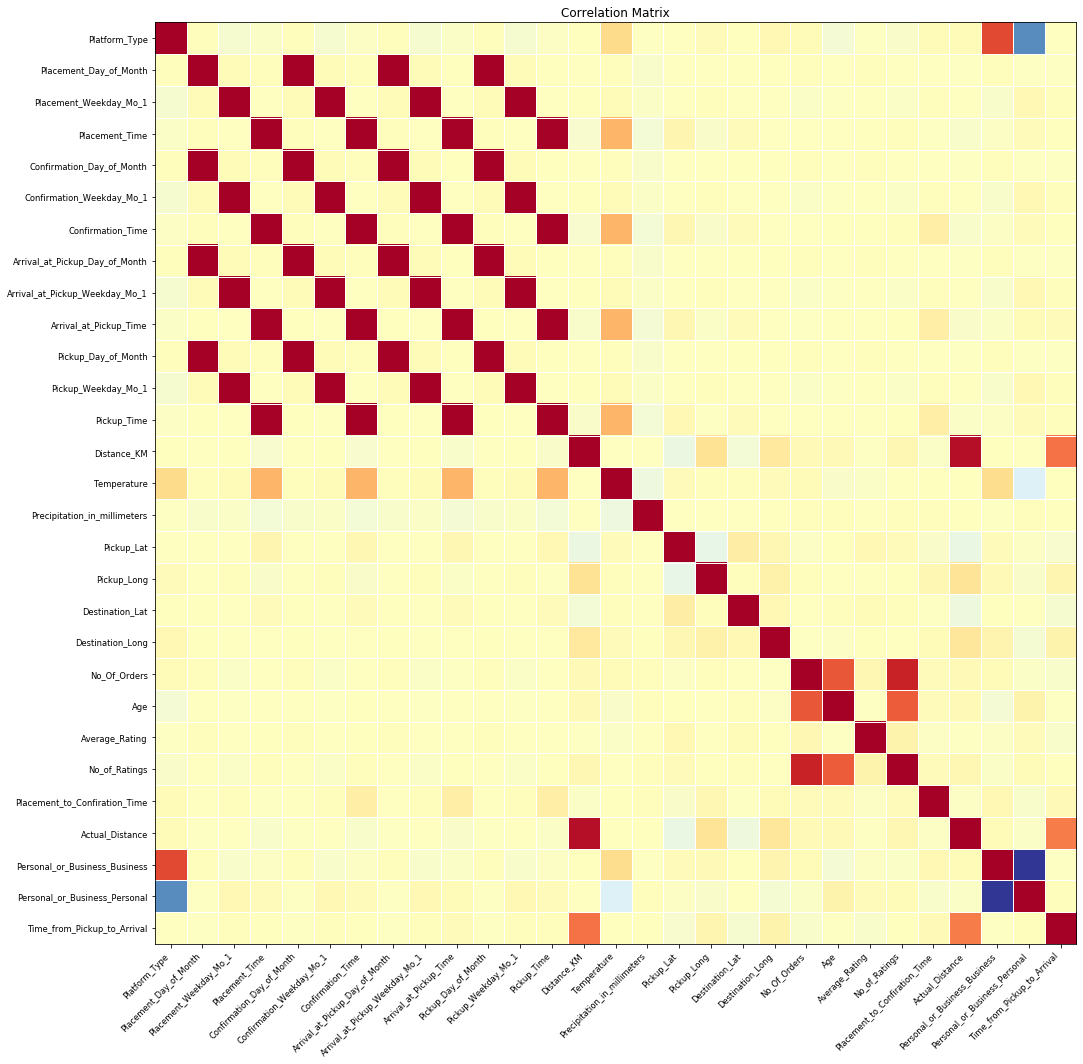

In [26]:
fig = plt.figure(figsize=(15,15));
ax = fig.add_subplot(111);
plot_corr(df_dummies.corr(), xnames = df_dummies.corr().columns, ax = ax);

If all of these variables are to be used, it would be like effectively working with superfluous or redundant information. The model will also have collinearity issues:

Peronal_or_Business_Personal and peronal_or_Business_Business are perfectly negative correlated. All the features having blue squeres are also perfectly negative correlated.
This will likely be a problem when building a model.

checking what an OLS model summary says.

## Fitting the model using statsmodels.OLS

#### Generating the regression string
Following the process initially detailed in the Multiple Linear Regression Pt 2 - Checking Model Quality train, OLS model will be build and the model summary will be printed:

y ~ X

which is read as follows: "Regress y on X". statsmodels works in a similar way, so an appropriate string need to be generated to feed to the method in case it is required to fit the model.

In [27]:
# Model DataFrame with all of the columns:
dfm = df_dummies.copy()

# The dependent variable:
y_name = 'Time_from_Pickup_to_Arrival'
# The independent variable
# (let's first try all of the columns in the model DataFrame)
X_names = [col for col in dfm.columns if col != y_name]

# Build the OLS formula string " y ~ X "
formula_str = y_name+" ~ "+" + ".join(X_names);
print('Formula:\n\t {}'.format(formula_str))

Formula:
	 Time_from_Pickup_to_Arrival ~ Platform_Type + Placement_Day_of_Month + Placement_Weekday_Mo_1 + Placement_Time + Confirmation_Day_of_Month + Confirmation_Weekday_Mo_1 + Confirmation_Time + Arrival_at_Pickup_Day_of_Month + Arrival_at_Pickup_Weekday_Mo_1 + Arrival_at_Pickup_Time + Pickup_Day_of_Month + Pickup_Weekday_Mo_1 + Pickup_Time + Distance_KM + Temperature + Precipitation_in_millimeters + Pickup_Lat + Pickup_Long + Destination_Lat + Destination_Long + No_Of_Orders + Age + Average_Rating + No_of_Ratings + Placement_to_Confiration_Time + Actual_Distance + Personal_or_Business_Business + Personal_or_Business_Personal


In [28]:
# Fitting the model using the model dataframe
model=ols(formula=formula_str, data=dfm)
fitted = model.fit()

# Output the fitted summary
print(fitted.summary())

                                 OLS Regression Results                                
Dep. Variable:     Time_from_Pickup_to_Arrival   R-squared:                       0.378
Model:                                     OLS   Adj. R-squared:                  0.377
Method:                          Least Squares   F-statistic:                     612.9
Date:                         Thu, 28 May 2020   Prob (F-statistic):               0.00
Time:                                 01:11:56   Log-Likelihood:            -1.7123e+05
No. Observations:                        21201   AIC:                         3.425e+05
Df Residuals:                            21179   BIC:                         3.427e+05
Df Model:                                   21                                         
Covariance Type:                     nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

There is warning about strong multicollinearity. This is likely as a result of the incorrect filtering of one hot encoded dummy variables (It was noticed earlier that Peronal_or_Business_Personal and peronal_or_Business_Business are perfectly negative correlated).

In order to ensure an underlying relationship between the categories is not assumed, pd.get_dummies is called with the argument drop_first=True so that only  n-1 columns are create for each variable with n categories.

In [29]:
df_dummies = pd.get_dummies(Train_df, drop_first=True)

# Again make sure that all the column names have underscores instead of whitespaces
df_dummies.columns = [col.replace(" ", "_") for col in df_dummies.columns]
df_dummies.columns = [col.replace("(Mo_=_1)","Mo_1") for col in df_dummies.columns]
df_dummies.columns = [col.replace("(KM)","KM") for col in df_dummies.columns]

# Reorder columns with the dependent variable (claim_amount) the last column
column_titles = [col for col in df_dummies.columns if col !=
                 'Time_from_Pickup_to_Arrival'] + ['Time_from_Pickup_to_Arrival']
df_dummies = df_dummies.reindex(columns=column_titles)

df_dummies.head()

,Platform_Type,Placement_Day_of_Month,Placement_Weekday_Mo_1,Placement_Time,Confirmation_Day_of_Month,Confirmation_Weekday_Mo_1,Confirmation_Time,Arrival_at_Pickup_Day_of_Month,Arrival_at_Pickup_Weekday_Mo_1,Arrival_at_Pickup_Time,...,Destination_Lat,Destination_Long,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Placement_to_Confiration_Time,Actual_Distance,Personal_or_Business_Personal,Time_from_Pickup_to_Arrival
0,3,9,5,34546.0,9,5,34810.0,9,5,36287.0,...,-1.300406,36.829741,1637,1309,13.8,549,264.0,2.0,0,745
1,3,12,5,40576.0,12,5,41001.0,12,5,42022.0,...,-1.295004,36.814358,396,339,13.6,69,425.0,11.0,1,1993
2,3,30,2,45565.0,30,2,45764.0,30,2,46174.0,...,-1.300921,36.828195,1023,242,12.5,114,199.0,2.0,0,455
3,3,15,5,33934.0,15,5,33965.0,15,5,34676.0,...,-1.257147,36.795063,886,283,14.5,113,31.0,5.0,0,1341
4,1,13,1,35718.0,13,1,35778.0,13,1,36233.0,...,-1.295041,36.809817,2311,872,14.1,533,60.0,3.0,1,1214


In [30]:
df_dummies.shape

(21201, 28)

Now there are 28 columns instead of 39. This gives for 28 potential independent variables that could be used to build a relationship on Time_from_Pickup_to_Arrival

Checking what the OLS model summary would say if now only the 30 variable columns are fit

In [31]:
# The model DataFrame will be kept, but only specify the columns wanted to fit this time
X_names = [col for col in df_dummies.columns if col != y_name]

# Build the OLS formula string " y ~ X "
formula_str = y_name+' ~ '+'+'.join(X_names)

# Fit the model using the model dataframe
model = ols(formula=formula_str, data=dfm)
fitted = model.fit()

# Output the fitted summary
print(fitted.summary())

                                 OLS Regression Results                                
Dep. Variable:     Time_from_Pickup_to_Arrival   R-squared:                       0.378
Model:                                     OLS   Adj. R-squared:                  0.377
Method:                          Least Squares   F-statistic:                     612.9
Date:                         Thu, 28 May 2020   Prob (F-statistic):               0.00
Time:                                 01:12:10   Log-Likelihood:            -1.7123e+05
No. Observations:                        21201   AIC:                         3.425e+05
Df Residuals:                            21179   BIC:                         3.427e+05
Df Model:                                   21                                         
Covariance Type:                     nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

The condition number has improved, but there is still mention of strong multicollinearity in warning [2]

Making further selections on the variables now using their significance.



## Variable Selection by Correlation and Significance

now there are 30 predictor variables to choose from, a way of guiding is needed to choose the best ones to be predictors. One way is to look at the correlations between the Time_from_Pickup_to_Arrival and each variables in the DataFrame and select those with the strongest correlations (both positive and negative).

To consider how significant those features are.
The code below will create a new DataFrame and store the correlation coefficents and p-values in that DataFrame for reference.

In [32]:
# Calculating correlations between predictor variables and the response variable
corrs = df_dummies.corr()['Time_from_Pickup_to_Arrival'].sort_values(ascending=False)

In [33]:

# a dictionary of correlation coefficients and p-values
dict_cp = {}

column_titles = [col for col in corrs.index if col!= 'Time_from_Pickup_to_Arrival']
for col in column_titles:
    p_val = round(pearsonr(df_dummies[col], df_dummies['Time_from_Pickup_to_Arrival'])[1],6)
    dict_cp[col] = {'Correlation_Coefficient':corrs[col],
                    'P_Value':p_val}

df_cp = pd.DataFrame(dict_cp).T
df_cp_sorted = df_cp.sort_values('P_Value')
df_cp_sorted[df_cp_sorted['P_Value']<0.1]

,Correlation_Coefficient,P_Value
Distance_KM,0.580608,0.000000
Average_Rating,-0.042559,0.000000
No_Of_Orders,-0.041608,0.000000
Pickup_Lat,-0.053823,0.000000
Destination_Lat,-0.061872,0.000000
Pickup_Long,0.060285,0.000000
Destination_Long,0.070425,0.000000
Placement_to_Confiration_Time,0.035489,0.000000
Actual_Distance,0.553877,0.000000
Arrival_at_Pickup_Time,0.018379,0.007447


Above is the sorted list of the p-values and correlation coefficients for each of the features, when considered on their own.

If a logic test was to be used with a significance value of 5% (p-value < 0.05),it would imply that the following features are statistically significant:
- Distance_KM
- Average_Rating
- the Coordinates (pick long and lat, dest long and lat)
- No-of_Orders
- Arrival_at_Destination_time
- Actual_Distance
- Placement_to_Destination_Time
- Arrived_at_Pickup_Time
- Placement_Day_od_Month
- Confirmation_Day_of_Month
- Pickup_Day_Of_Month
- Arrival_at_Pickup_Day_of_Month


the variables that have a significant correlation with the dependent variable are kept.they will be put into an independent variable DataFrame X

In [34]:
# The dependent variable remains the same:
y_data = df_dummies[y_name]  # y_name = 'Time_from_Pickup_to_Arrival'

# Model building - Independent Variable (IV) DataFrame
X_names = list(df_cp[df_cp['P_Value'] < 0.05].index)
X_data = df_dummies[X_names]

To avoid autocorrelation,it is needed to look for predictor variable pairs which have a high correlation with each other.

In [35]:
# Creating the correlation matrix
corr = X_data.corr()

# Find rows and columnd where correlation coefficients > 0.9 or <-0.9
corr[np.abs(corr) > 0.9]

,Distance_KM,Actual_Distance,Destination_Long,Pickup_Long,Placement_to_Confiration_Time,Arrival_at_Pickup_Time,Arrival_at_Pickup_Day_of_Month,Pickup_Day_of_Month,Confirmation_Day_of_Month,Placement_Day_of_Month,No_Of_Orders,Average_Rating,Pickup_Lat,Destination_Lat
Distance_KM,1.000000,0.937356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Actual_Distance,0.937356,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Destination_Long,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pickup_Long,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Placement_to_Confiration_Time,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arrival_at_Pickup_Time,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arrival_at_Pickup_Day_of_Month,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,0.999998,NaN,NaN,NaN,NaN
Pickup_Day_of_Month,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,0.999998,NaN,NaN,NaN,NaN
Confirmation_Day_of_Month,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,0.999998,NaN,NaN,NaN,NaN
Placement_Day_of_Month,NaN,NaN,NaN,NaN,NaN,NaN,0.999998,0.999998,0.999998,1.000000,NaN,NaN,NaN,NaN


Instead of looking at the whole correlation matrix, it might be easier to isolate the sections of the correlation matrix to where the off-diagonal correlations are high:

In [36]:
# just like before, the correlation matrix is created
# rows and columnd where correlation coefficients > 0.9 or <-0.9
corr = X_data.corr()
r, c = np.where(np.abs(corr) > 0.9)

# The interest is in the off diagonal entries:
off_diagonal = np.where(r != c)

# Showing the correlation matrix rows and columns where there is  highly correlated off diagonal entries:
corr.iloc[r[off_diagonal], c[off_diagonal]]

,Actual_Distance,Distance_KM,Pickup_Day_of_Month,Confirmation_Day_of_Month,Placement_Day_of_Month,Arrival_at_Pickup_Day_of_Month,Confirmation_Day_of_Month,Placement_Day_of_Month,Arrival_at_Pickup_Day_of_Month,Pickup_Day_of_Month,Placement_Day_of_Month,Arrival_at_Pickup_Day_of_Month,Pickup_Day_of_Month,Confirmation_Day_of_Month
Distance_KM,0.937356,1.000000,-0.007587,-0.007587,-0.007585,-0.007587,-0.007587,-0.007585,-0.007587,-0.007587,-0.007585,-0.007587,-0.007587,-0.007587
Actual_Distance,1.000000,0.937356,-0.008251,-0.008251,-0.008251,-0.008251,-0.008251,-0.008251,-0.008251,-0.008251,-0.008251,-0.008251,-0.008251,-0.008251
Arrival_at_Pickup_Day_of_Month,-0.008251,-0.007587,1.000000,1.000000,0.999998,1.000000,1.000000,0.999998,1.000000,1.000000,0.999998,1.000000,1.000000,1.000000
Arrival_at_Pickup_Day_of_Month,-0.008251,-0.007587,1.000000,1.000000,0.999998,1.000000,1.000000,0.999998,1.000000,1.000000,0.999998,1.000000,1.000000,1.000000
Arrival_at_Pickup_Day_of_Month,-0.008251,-0.007587,1.000000,1.000000,0.999998,1.000000,1.000000,0.999998,1.000000,1.000000,0.999998,1.000000,1.000000,1.000000
Pickup_Day_of_Month,-0.008251,-0.007587,1.000000,1.000000,0.999998,1.000000,1.000000,0.999998,1.000000,1.000000,0.999998,1.000000,1.000000,1.000000
Pickup_Day_of_Month,-0.008251,-0.007587,1.000000,1.000000,0.999998,1.000000,1.000000,0.999998,1.000000,1.000000,0.999998,1.000000,1.000000,1.000000
Pickup_Day_of_Month,-0.008251,-0.007587,1.000000,1.000000,0.999998,1.000000,1.000000,0.999998,1.000000,1.000000,0.999998,1.000000,1.000000,1.000000
Confirmation_Day_of_Month,-0.008251,-0.007587,1.000000,1.000000,0.999998,1.000000,1.000000,0.999998,1.000000,1.000000,0.999998,1.000000,1.000000,1.000000
Confirmation_Day_of_Month,-0.008251,-0.007587,1.000000,1.000000,0.999998,1.000000,1.000000,0.999998,1.000000,1.000000,0.999998,1.000000,1.000000,1.000000


Okay, so it looks like six of the features are very highly correlated.

This is also visible looking back at the correlation coefficient heatmap and matrix from earlier, but a more focused / subset view of the matrix is useful to isolate the coefficients of interest.

Distance is slightly better correlated (and lower p-value) to the dependent variable Loan Size
there fore; Arrival_at_Pickip_day_of_Month, Pickup_Day_of_Month, Confirmation_Day_of_Month and Placement_Day_of_Month are dropped form the feature dataframe. 
The resulting OLS fit summary:

In [37]:
# a new subset of potential independent variables
X_remove = ['Arrival_at_Pickip_day_of_Month', 'Pickup_Day_of_Month', 'Confirmation_Day_of_Month', 'Placement_Day_of_Month']
X_corr_names = [col for col in X_names if col not in X_remove]

# Creating new OLS formula based-upon the smaller subset
formula_str = y_name+' ~ '+' + '.join(X_corr_names);
print('Formula:\n\t{}'.format(formula_str))

Formula:
	Time_from_Pickup_to_Arrival ~ Distance_KM + Actual_Distance + Destination_Long + Pickup_Long + Placement_to_Confiration_Time + Arrival_at_Pickup_Time + Arrival_at_Pickup_Day_of_Month + No_Of_Orders + Average_Rating + Pickup_Lat + Destination_Lat


In [38]:
# Fit the OLS model using the model dataframe
model=ols(formula=formula_str, data=dfm)
fitted = model.fit()

# Display the fitted summary
print(fitted.summary())

                                 OLS Regression Results                                
Dep. Variable:     Time_from_Pickup_to_Arrival   R-squared:                       0.350
Model:                                     OLS   Adj. R-squared:                  0.349
Method:                          Least Squares   F-statistic:                     1036.
Date:                         Thu, 28 May 2020   Prob (F-statistic):               0.00
Time:                                 01:25:44   Log-Likelihood:            -1.7170e+05
No. Observations:                        21201   AIC:                         3.434e+05
Df Residuals:                            21189   BIC:                         3.435e+05
Df Model:                                   11                                         
Covariance Type:                     nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

### Variable Selection by Variance Thresholds

Variance Thresholds remove features whose values don't change much from observation to observation. The objective here is to remove all features that have a variance lower than the selected threshold.

It is important to note that variance is dependent on scale, so the features will have to be normalized before implementing variance thresholding.

In [39]:
# Separating data into independent (X) and independent (y) variables
X_names = list(df_dummies.columns)
X_names.remove(y_name)
X_data = df_dummies[X_names]
y_data = df_dummies[y_name]

In [40]:
# Normalizing data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_data)
X_normalize = pd.DataFrame(X_scaled, columns=X_data.columns)

### Variance Threshold in Scikit Learn

To implement Variance Threshold in Scikit Learn:

Import and create an instance of the VarianceThreshold class;
Using the .fit() method to select subset of features based on the threshold.

In [41]:
# Create VarianceThreshold object
selector = VarianceThreshold(threshold=0.03)

# Using the object to apply the threshold on data
selector.fit(X_normalize)

VarianceThreshold(threshold=0.03)

The Variance Threshold has been applied to the data.Now a closer look at the calculated variance for each predictive variable.

In [42]:
# Getting column variances
column_variances = selector.variances_

vars_dict = {}
vars_dict = [{"Variable_Name": c_name, "Variance": c_var}
             for c_name, c_var in zip(X_normalize.columns, column_variances)]
df_vars = pd.DataFrame(vars_dict)
df_vars.sort_values(by='Variance', ascending=False)

,Variable_Name,Variance
26,Personal_or_Business_Personal,0.147625
1,Placement_Day_of_Month,0.086019
10,Pickup_Day_of_Month,0.086019
4,Confirmation_Day_of_Month,0.086019
7,Arrival_at_Pickup_Day_of_Month,0.086019
2,Placement_Weekday_Mo_1,0.068231
5,Confirmation_Weekday_Mo_1,0.068225
11,Pickup_Weekday_Mo_1,0.068225
8,Arrival_at_Pickup_Weekday_Mo_1,0.068225
0,Platform_Type,0.043425


The above table shows the variances of the individual columns before any threshold is applied. It allows anyone to revise  initial variance threshold if there might be a need to exclude important variables.

The results needs to be extracted and used to select new columns - which form a subset of all the columns.

In [43]:
# Selecting new columns
X_new = X_normalize[X_normalize.columns[selector.get_support(indices=True)]]

# Saving variable names for later
X_var_names = X_new.columns

# Viewing first few entries
X_new.head()

,Platform_Type,Placement_Day_of_Month,Placement_Weekday_Mo_1,Confirmation_Day_of_Month,Confirmation_Weekday_Mo_1,Arrival_at_Pickup_Day_of_Month,Arrival_at_Pickup_Weekday_Mo_1,Pickup_Day_of_Month,Pickup_Weekday_Mo_1,Age,No_of_Ratings,Personal_or_Business_Personal
0,0.666667,0.266667,0.666667,0.266667,0.666667,0.266667,0.666667,0.266667,0.666667,0.330698,0.238903,0.0
1,0.666667,0.366667,0.666667,0.366667,0.666667,0.366667,0.666667,0.366667,0.666667,0.066249,0.030026,1.0
2,0.666667,0.966667,0.166667,0.966667,0.166667,0.966667,0.166667,0.966667,0.166667,0.039804,0.049608,0.0
3,0.666667,0.466667,0.666667,0.466667,0.666667,0.466667,0.666667,0.466667,0.666667,0.050981,0.049173,0.0
4,0.000000,0.400000,0.000000,0.400000,0.000000,0.400000,0.000000,0.400000,0.000000,0.211559,0.231941,1.0


In [44]:
X_new.shape

(21201, 12)

With a threshold of 0.03, the predictor number has gone from 29 to 12 predictors.

Trying few more few more thresholds

In [45]:
# Creating Variance Threshold objects
selector_1 = VarianceThreshold(threshold=0.05)
selector_2 = VarianceThreshold(threshold=0.1)
selector_3 = VarianceThreshold(threshold=0.15)

In [46]:
selector_1.fit(X_normalize)

VarianceThreshold(threshold=0.05)

In [47]:
selector_2.fit(X_normalize)

VarianceThreshold(threshold=0.1)

selector_3.fit(X_normalize)

ValueError                                Traceback (most recent call last)
<ipython-input-48-3b888a91ae87> in <module>
----> 1 selector_3.fit(X_normalize)

~\Anaconda3\lib\site-packages\sklearn\feature_selection\_variance_threshold.py in fit(self, X, y)
     90             if X.shape[0] == 1:
     91                 msg += " (X contains only one sample)"
---> 92             raise ValueError(msg.format(self.threshold))
     93 
     94         return self

ValueError: No feature in X meets the variance threshold 0.15000

In [50]:
X_1 = X_normalize[X_normalize.columns[selector_1.get_support(indices=True)]]
X_2 = X_normalize[X_normalize.columns[selector_2.get_support(indices=True)]]
X_3 = X_normalize[X_normalize.columns[selector_3.get_support(indices=True)]]

 graphing the number of predictors by the thresholds to investigate the relationship

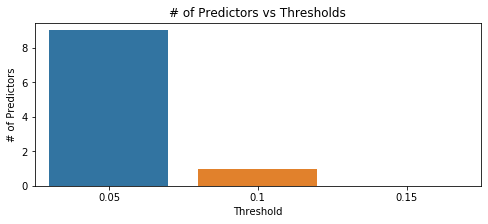

In [51]:
f, ax = plt.subplots(figsize=(8, 3), nrows=1, ncols=1)

# Create list of titles and predictions to use in for loop
subset_preds = [X_1.shape[1], X_2.shape[1], X_3.shape[1]]
thresholds = ['0.05', '0.1', '0.15']

# Plot graph
ax.set_title('# of Predictors vs Thresholds')
ax.set_ylabel('# of Predictors')
ax.set_xlabel('Threshold')
sns.barplot(x=thresholds, y=subset_preds)
plt.show()

an increase the threshold, the number of dimensions decrease

checking what the resulting OLS fit summary for a threshold of 0.03 says:

In [52]:
# new OLS formula
formula_str = y_name+' ~ '+' + '.join(X_new.columns)
print('Formula:\n\t{}'.format(formula_str))

Formula:
	Time_from_Pickup_to_Arrival ~ Platform_Type + Placement_Day_of_Month + Placement_Weekday_Mo_1 + Confirmation_Day_of_Month + Confirmation_Weekday_Mo_1 + Arrival_at_Pickup_Day_of_Month + Arrival_at_Pickup_Weekday_Mo_1 + Pickup_Day_of_Month + Pickup_Weekday_Mo_1 + Age + No_of_Ratings + Personal_or_Business_Personal


In [53]:
# Fitting the model using the model dataframe
model = ols(formula=formula_str, data=df_dummies)
fitted = model.fit()

print(fitted.summary())

                                 OLS Regression Results                                
Dep. Variable:     Time_from_Pickup_to_Arrival   R-squared:                       0.001
Model:                                     OLS   Adj. R-squared:                  0.001
Method:                          Least Squares   F-statistic:                     2.629
Date:                         Thu, 28 May 2020   Prob (F-statistic):             0.0103
Time:                                 01:30:24   Log-Likelihood:            -1.7625e+05
No. Observations:                        21201   AIC:                         3.525e+05
Df Residuals:                            21193   BIC:                         3.526e+05
Df Model:                                    7                                         
Covariance Type:                     nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

### modelling the Loan Size¶
Now that the DataFrame has been shortened using various methods, Its time to see if  linear regression models can be fit and compare them

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

### Preprocess data
Assuring that all models are trained and tested on the same data.

In [74]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_data,
                                                    y_data,
                                                    test_size=0.20,
                                                    shuffle=False)

In [75]:
# Get training and testing data for variance threshold model
X_var_train = X_train[X_var_names]
X_var_test = X_test[X_var_names]

In [76]:
# Get training and testing data for correlation threshold model
X_corr_train = X_train[X_corr_names]
X_corr_test = X_test[X_corr_names]

Fitting models
instantiate and fit our models

In [78]:
lm = LinearRegression()
lm_corr = LinearRegression()
lm_var = LinearRegression()

In [79]:
lm.fit(X_train, y_train);
lm_corr.fit(X_corr_train,y_train);
lm_var.fit(X_var_train,y_train);

#### Assessing model accuracy
checking how the linear models performed!

In [80]:
from sklearn.metrics import mean_squared_error, r2_score

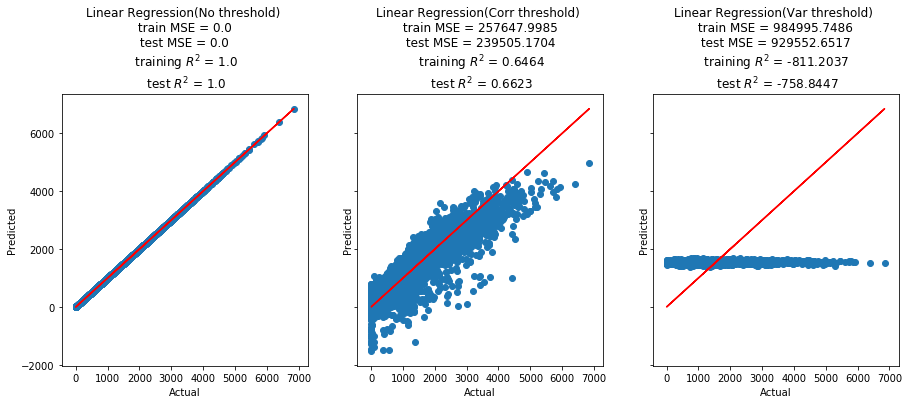

In [81]:
# Creating figure and axes
f, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=3, sharey=True)

# Creating list of titles and predictions to use in for loop
train_pred = [lm.predict(X_train),
              lm_corr.predict(X_corr_train),
              lm_var.predict(X_var_train)]
test_pred = [lm.predict(X_test),
             lm_corr.predict(X_corr_test),
             lm_var.predict(X_var_test)]
title = ['No threshold', 'Corr threshold', 'Var threshold']

# Key:
# No threshold - linear regression with all predictive variables
# Corr threshold - linear regression with correlation thresholded predictive variables
# Var threshold - linear regression with variance thresholded predictive variables


# Loop through all axes to plot each model's results
for i in range(3):
    test_mse = round(mean_squared_error(test_pred[i], y_test), 4)
    test_r2 = round(r2_score(test_pred[i], y_test), 4)
    train_mse = round(mean_squared_error(train_pred[i], y_train), 4)
    train_r2 = round(r2_score(train_pred[i], y_train), 4)
    title_str = f"Linear Regression({title[i]}) \n train MSE = {train_mse} \n " + \
                f"test MSE = {test_mse} \n training $R^{2}$ = {train_r2} \n " + \
                f"test $R^{2}$ = {test_r2}"
    ax[i].set_title(title_str)
    ax[i].set_xlabel('Actual')
    ax[i].set_ylabel('Predicted')
    ax[i].plot(y_test, y_test, 'r')
    ax[i].scatter(y_test, test_pred[i])